<a href="https://colab.research.google.com/github/Kobai/name-that-genre/blob/master/lyric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import string
import re
from os import listdir
from numpy import array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, Input, Dropout, concatenate
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from collections import Counter
import pandas as pd

Lyrics data was acquired from https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics

In [0]:
from zipfile import ZipFile
with ZipFile('lyrics.zip', 'r') as zipObj:
  zipObj.extractall()

In [0]:
import pandas as pd
df = pd.read_csv('lyrics.csv')

In [0]:
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [0]:
# We'll drop these columns because we want to classify genres only by lyrics
df = df.drop(columns=['index', 'song', 'year', 'artist'])

In [0]:
df.to_csv('small_lyrics.csv', index=False)

In [0]:
# Print out of the lyrics for the first song. As we can see, there's a lot of cleaning to be done
df['lyrics'].head()[0]

"Oh baby, how you doing?\nYou know I'm gonna cut right to the chase\nSome women were made but me, myself\nI like to think that I was created for a special purpose\nYou know, what's more special than you? You feel me\nIt's on baby, let's get lost\nYou don't need to call into work 'cause you're the boss\nFor real, want you to show me how you feel\nI consider myself lucky, that's a big deal\nWhy? Well, you got the key to my heart\nBut you ain't gonna need it, I'd rather you open up my body\nAnd show me secrets, you didn't know was inside\nNo need for me to lie\nIt's too big, it's too wide\nIt's too strong, it won't fit\nIt's too much, it's too tough\nHe talk like this 'cause he can back it up\nHe got a big ego, such a huge ego\nI love his big ego, it's too much\nHe walk like this 'cause he can back it up\nUsually I'm humble, right now I don't choose\nYou can leave with me or you could have the blues\nSome call it arrogant, I call it confident\nYou decide when you find on what I'm working 

## Data Preparation

In [0]:
def clean_lyrics(doc):
  stemmer = PorterStemmer()
  # We don't really care about the line breaks. we want to see the lyrics as a single sequence
  doc.replace('\n', ' ') 
  tokens = doc.split()

  # Remove the punctuation and only keep words with alphabet characters
  re_punc = re.compile(f'[{re.escape(string.punctuation)}]') 
  tokens = [re_punc.sub('',w) for w in tokens] 
  tokens = [word for word in tokens if word.isalpha()]

  # Remove stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]

  # Remove 1 letter words and lower case everything
  tokens = [word for word in tokens if len(word) >1]
  tokens = [word.lower() for word in tokens]

  # Stem the words using porter stemmer
  tokens = [stemmer.stem(word) for word in tokens]
  return ' '.join(tokens)

def is_english(doc):
  tokens = doc.split()
  counter = 0
  # setting threshold for number of non-english words because contractions like didn't are not counted as english (room for improvement)
  threshold = int(len(tokens) * 0.3)
  for token in tokens:
    if not wordnet.synsets(token):
      counter +=1
    if counter >= threshold:
      return False
  return True

In [0]:
clean_lyrics(df['lyrics'].head()[0])

In [0]:
# Looks pretty good so we'll run the clean function on all the lyrics
df['lyrics'] = df['lyrics'].astype(str).apply(lambda x: clean_lyrics(x))

In [0]:
df = df[df['lyrics'] != 'nan' ]

In [0]:
df = df[df.apply(lambda x: is_english(x['lyrics']), axis=1)]

In [0]:
df.to_csv('clean_lyrics.csv', index=False)

In [0]:
df = pd.read_csv('clean_lyrics.csv')

## EDA

From running the cell below, we can see that the genres are not well distributed. The dataset is heavily weighted towards Rock

Pop: 21219
Hip-Hop: 10950
Rock: 68845
Metal: 15324
Other: 2531
Country: 9678
Jazz: 4625
Electronic: 4387
Folk: 1240
Indie: 2198
R&B: 2004


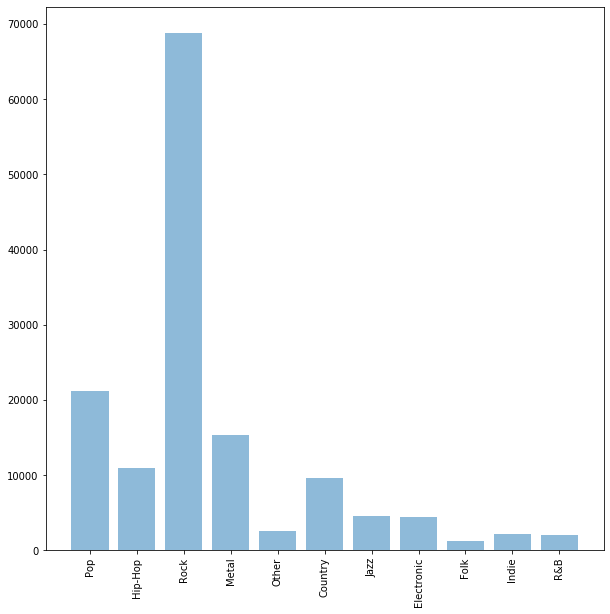

In [12]:
fig, ax = plt.subplots(figsize=(10,10)) 

counts = []
for genre in df['genre'].unique().tolist():
  print(f'{genre}: {df[df["genre"] == genre]["genre"].count()}')
  counts.append(df[df["genre"] == genre]["genre"].count())
  
objects = df['genre'].unique().tolist()
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize=10, rotation=90)
plt.show()

In [0]:
# There were also a lot of Not available so we'll get rid of those
df = df[df['genre'] != 'Not Available']
genres = df['genre'].unique().tolist()

count    140402.000000
mean        610.682433
std         352.998530
min          30.000000
25%         373.000000
50%         530.500000
75%         746.000000
max        2200.000000
Name: strlen, dtype: float64


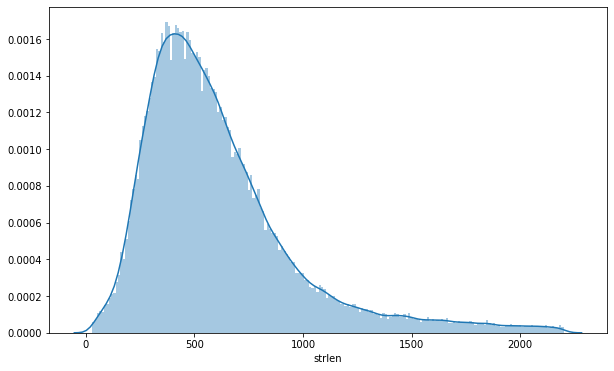

In [23]:
df['strlen'] = df['lyrics'].str.len()
print(df['strlen'].describe())
fig, ax = plt.subplots(figsize=(10,6)) 
sn.distplot(df['strlen'],bins=200)

In [0]:
df = df[df['strlen'] >= 30]
df = df[df['strlen'] <= 2200]

In [0]:
lines = df['lyrics'].tolist()

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)

In [26]:
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocab Size: {vocab_size}')
max_length = max([len(s.split()) for s in lines])
print(f'Max Length: {max_length}')

Vocab Size: 94737
Max Length: 528


In [0]:
def encode_docs(vocab_size, max_length, docs):
  encoded = tokenizer.texts_to_sequences(docs)
  padded = pad_sequences(encoded, maxlen=max_length, padding='post')
  return padded

In [0]:
def define_model(vocab_size, max_length):
  inputs1 = Input(shape=(max_length,))
  embedding1 = Embedding(vocab_size, 100)(inputs1)
  conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  inputs2 = Input(shape=(max_length,))
  embedding2 = Embedding(vocab_size, 100)(inputs2)
  conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  inputs3 = Input(shape=(max_length,))
  embedding3 = Embedding(vocab_size, 100)(inputs3)
  conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  merged = concatenate([flat1, flat2, flat3])
  dense1 = Dense(64, activation='relu')(merged)
  dense2 = Dense(32, activation='relu')(dense1)
  outputs = Dense(11, activation='softmax')(dense2)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  plot_model(model, to_file='model.png', show_shapes=True)
  return model

In [0]:
def test_model(model):
  rev_genre_dict = dict(zip(range(11), genres))
  preds = model.predict([Xtest, Xtest, Xtest])
  preds = [np.argmax(pred) for pred in preds]
  labels = [np.argmax(label) for label in ytest]
  print(classification_report(labels, preds))
  cm = confusion_matrix(labels, preds)
  cm_df = pd.DataFrame(cm, index=genres, columns=genres)
  fig, ax = plt.subplots(figsize=(18,11)) 
  sn.set(font_scale=1.4)
  sn.heatmap(cm_df, annot=True, annot_kws={'size': 12}, linewidths=0.5, cmap="Blues") 

In [31]:
X = encode_docs(tokenizer, max_length, lines)
genre_dict = dict(zip(genres, range(11)))
print(genre_dict)
y = df['genre'].astype(str).apply(lambda x: genre_dict[x]).tolist()
y = to_categorical(y, num_classes=11)

{'Pop': 0, 'Hip-Hop': 1, 'Rock': 2, 'Metal': 3, 'Other': 4, 'Country': 5, 'Jazz': 6, 'Electronic': 7, 'Folk': 8, 'Indie': 9, 'R&B': 10}


In [0]:
from sklearn.model_selection import train_test_split
(Xtrain, Xtest, ytrain, ytest) = train_test_split(X,y,test_size=0.2, random_state=42)

In [35]:
model = define_model(vocab_size, max_length)
model.fit([Xtrain, Xtrain, Xtrain], ytrain, epochs=7, batch_size=128)
model.save('model.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 528)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 528)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 528)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 528, 100)     9473700     input_4[0][0]                    
____________________________________________________________________________________________

              precision    recall  f1-score   support

           0       0.40      0.43      0.41      4236
           1       0.75      0.74      0.75      1971
           2       0.64      0.75      0.69     13533
           3       0.68      0.50      0.58      2974
           4       0.18      0.07      0.10       501
           5       0.42      0.47      0.44      1931
           6       0.45      0.28      0.35       895
           7       0.38      0.16      0.22       919
           8       0.25      0.07      0.11       241
           9       0.24      0.07      0.11       452
          10       0.35      0.16      0.22       428

    accuracy                           0.58     28081
   macro avg       0.43      0.34      0.36     28081
weighted avg       0.56      0.58      0.56     28081



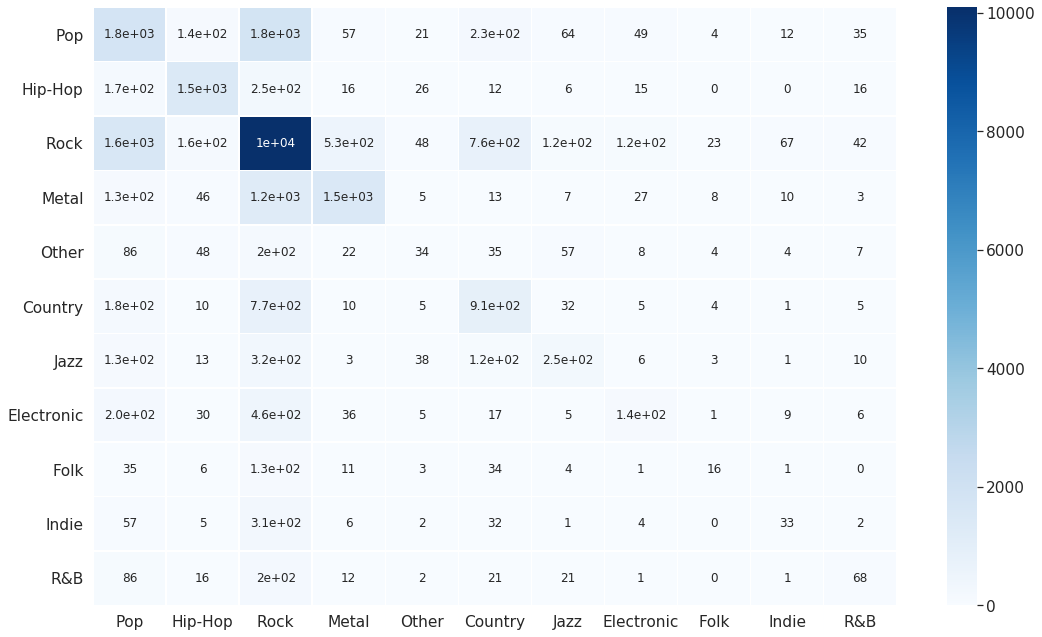

In [61]:
test_model(model)